 ## Image Classification with Deep Learning using MedMNIST

 This script demonstrates the classification of medical images using the BloodMNIST dataset.

 It includes dataset loading, preprocessing, training a CNN model, evaluation, and visualization.

 ### Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score
from medmnist import BloodMNIST, INFO
from tqdm import tqdm


 ### Load BloodMNIST Dataset and Display Montage

100%|██████████| 35.5M/35.5M [00:28<00:00, 1.24MB/s]


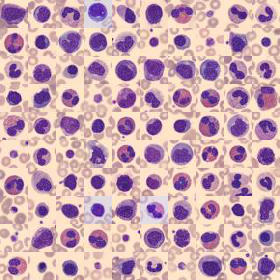

In [4]:
data_flag = 'bloodmnist'
info = INFO[data_flag]
n_channels = info['n_channels']
n_classes = len(info['label'])
im_size = 28

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_set = BloodMNIST(split='train', transform=data_transform, download=True)
val_set = BloodMNIST(split='val', transform=data_transform, download=True)
test_set = BloodMNIST(split='test', transform=data_transform, download=True)

# Display a montage of images from the training set
train_set.montage(length=10)


 ### Define and Initialize the CNN Model

In [5]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes, im_size):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * (im_size // 2) * (im_size // 2), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Model initialization
model = Net(in_channels=n_channels, num_classes=n_classes, im_size=im_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=8, bias=True)
)

 ### Define Training Parameters and DataLoaders

In [6]:
NUM_EPOCHS = 20
BATCH_SIZE = 128
lr = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loader = data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_set, batch_size=2 * BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_set, batch_size=2 * BATCH_SIZE, shuffle=False)


 ### Training Loop with Loss Monitoring

In [7]:
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device).float(), targets.to(device).squeeze().long()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device).float(), targets.to(device).squeeze().long()
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


100%|██████████| 94/94 [00:09<00:00,  9.93it/s]


Epoch [1/20], Train Loss: 0.9017, Val Loss: 0.4884


100%|██████████| 94/94 [00:08<00:00, 11.23it/s]


Epoch [2/20], Train Loss: 0.4115, Val Loss: 0.3841


100%|██████████| 94/94 [00:08<00:00, 11.38it/s]


Epoch [3/20], Train Loss: 0.3159, Val Loss: 0.2917


100%|██████████| 94/94 [00:08<00:00, 11.15it/s]


Epoch [4/20], Train Loss: 0.2658, Val Loss: 0.2675


100%|██████████| 94/94 [00:08<00:00, 11.23it/s]


Epoch [5/20], Train Loss: 0.2309, Val Loss: 0.2703


100%|██████████| 94/94 [00:08<00:00, 10.81it/s]


Epoch [6/20], Train Loss: 0.2003, Val Loss: 0.2597


100%|██████████| 94/94 [00:08<00:00, 10.78it/s]


Epoch [7/20], Train Loss: 0.1730, Val Loss: 0.2522


100%|██████████| 94/94 [00:08<00:00, 10.63it/s]


Epoch [8/20], Train Loss: 0.1568, Val Loss: 0.2421


100%|██████████| 94/94 [00:08<00:00, 10.84it/s]


Epoch [9/20], Train Loss: 0.1337, Val Loss: 0.2381


100%|██████████| 94/94 [00:08<00:00, 10.79it/s]


Epoch [10/20], Train Loss: 0.1124, Val Loss: 0.2486


100%|██████████| 94/94 [00:08<00:00, 11.15it/s]


Epoch [11/20], Train Loss: 0.0920, Val Loss: 0.2382


100%|██████████| 94/94 [00:08<00:00, 10.81it/s]


Epoch [12/20], Train Loss: 0.0804, Val Loss: 0.2335


100%|██████████| 94/94 [00:08<00:00, 11.16it/s]


Epoch [13/20], Train Loss: 0.0623, Val Loss: 0.2557


100%|██████████| 94/94 [00:08<00:00, 11.44it/s]


Epoch [14/20], Train Loss: 0.0569, Val Loss: 0.2789


100%|██████████| 94/94 [00:08<00:00, 11.53it/s]


Epoch [15/20], Train Loss: 0.0465, Val Loss: 0.2566


100%|██████████| 94/94 [00:08<00:00, 11.68it/s]


Epoch [16/20], Train Loss: 0.0480, Val Loss: 0.2672


100%|██████████| 94/94 [00:08<00:00, 11.35it/s]


Epoch [17/20], Train Loss: 0.0323, Val Loss: 0.2590


100%|██████████| 94/94 [00:08<00:00, 11.72it/s]


Epoch [18/20], Train Loss: 0.0209, Val Loss: 0.2910


100%|██████████| 94/94 [00:08<00:00, 11.47it/s]


Epoch [19/20], Train Loss: 0.0158, Val Loss: 0.2988


100%|██████████| 94/94 [00:08<00:00, 11.37it/s]


Epoch [20/20], Train Loss: 0.0238, Val Loss: 0.3216


 ### Plot Training and Validation Losses

Val. losses:  [0.48841103059904917, 0.38407513925007414, 0.2917283688272749, 0.2674619598048074, 0.27027967146464754, 0.2596712665898459, 0.252216847879546, 0.24211349657603673, 0.23814004446778977, 0.24858378512518747, 0.23824857813971384, 0.23352921434811183, 0.255673776779856, 0.2789117055279868, 0.2565734492880957, 0.26723166022981915, 0.2589602938720158, 0.29098041568483624, 0.298769365463938, 0.32164030202797483]
Train losses:  [0.9016575493077015, 0.4114996939897537, 0.3158600133784274, 0.26580777423495944, 0.23093033471006028, 0.20027826964221102, 0.1729799356073775, 0.1567822802970384, 0.13366359706096193, 0.11243039769853683, 0.09195014933480862, 0.08039764065216197, 0.06229836387718295, 0.0569275609475184, 0.04650788238034286, 0.04795917018534655, 0.03232851013184545, 0.02094306679383079, 0.01577986515513522, 0.02379290706557321]


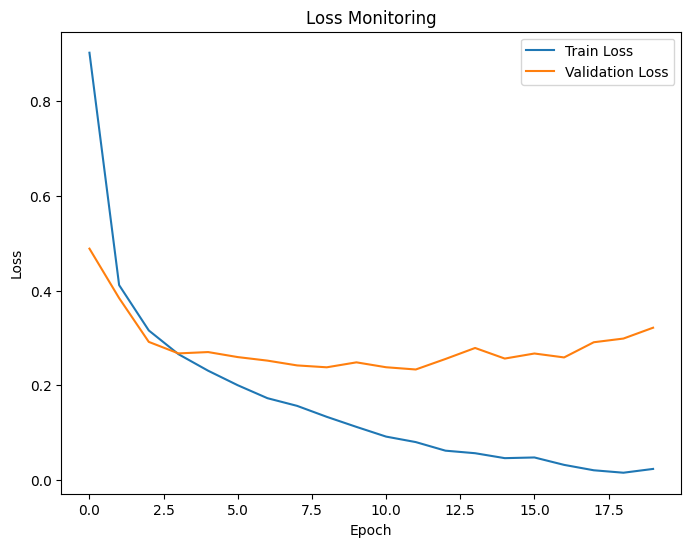

In [13]:
print("Val. losses: ", val_losses)
print("Train losses: ",train_losses)
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Monitoring")
plt.legend()
plt.show()


 ### Evaluation with Metrics and Visualization

Accuracy: 91.84%
Sensitivity: 0.9184
Specificity: 0.9212
F1 Score: 0.9181
AUC: 0.9428
Conf. Matrix:  [[198   4   1  31   2   4   4   0]
 [  1 616   1   2   0   0   4   0]
 [  0   2 294  10   1   1   2   1]
 [ 10   7  13 512   5  13  19   0]
 [  3   0  15  12 212   1   0   0]
 [  3   0   3  62   5 207   4   0]
 [  1   4   7  20   1   0 633   0]
 [  0   0   0   0   0   0   0 470]]


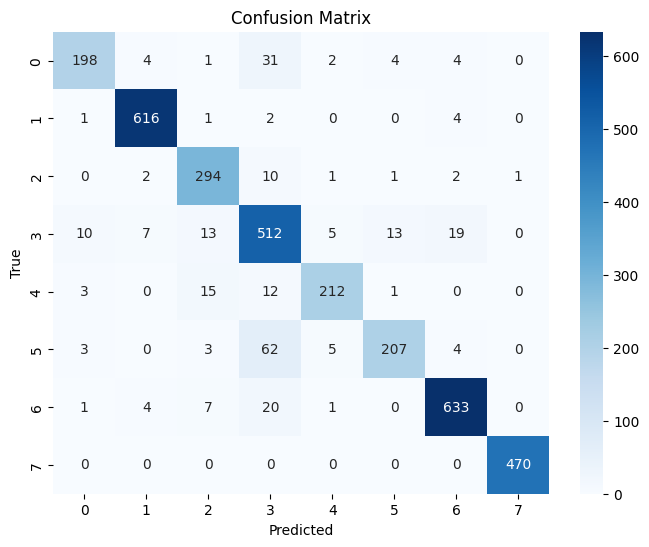

Conf. Matrix (Normalized):  [[ 81.14754098   1.63934426   0.40983607  12.70491803   0.81967213
    1.63934426   1.63934426   0.        ]
 [  0.16025641  98.71794872   0.16025641   0.32051282   0.
    0.           0.64102564   0.        ]
 [  0.           0.64308682  94.53376206   3.21543408   0.32154341
    0.32154341   0.64308682   0.32154341]
 [  1.72711572   1.208981     2.24525043  88.4283247    0.86355786
    2.24525043   3.28151986   0.        ]
 [  1.2345679    0.           6.17283951   4.9382716   87.24279835
    0.41152263   0.           0.        ]
 [  1.05633803   0.           1.05633803  21.83098592   1.76056338
   72.88732394   1.4084507    0.        ]
 [  0.15015015   0.6006006    1.05105105   3.003003     0.15015015
    0.          95.04504505   0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.         100.        ]]


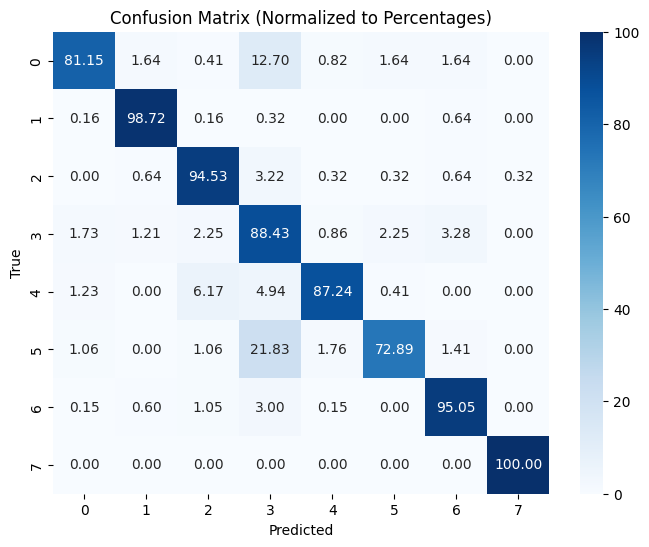

In [14]:
model.eval()
correct = 0
total = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device).float(), targets.to(device).squeeze().long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == targets).sum().item()
        total += targets.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

accuracy = 100 * correct / total
sensitivity = recall_score(all_targets, all_preds, average="weighted")
specificity = precision_score(all_targets, all_preds, average="weighted")
f1 = f1_score(all_targets, all_preds, average="weighted")
auc = roc_auc_score(np.eye(n_classes)[all_targets], np.eye(n_classes)[all_preds], multi_class='ovr')

print(f"Accuracy: {accuracy:.2f}%")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
print("Conf. Matrix: ", conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(n_classes), yticklabels=range(n_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Confusion Matrix (Normalized)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
print("Conf. Matrix (Normalized): ", conf_matrix_percent)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=range(n_classes), yticklabels=range(n_classes))
plt.title('Confusion Matrix (Normalized to Percentages)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
